# Dev Notebook

Baseline Model

In [1]:
import sys
import setproctitle
sys.path.append('../src')

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import SGD

from Models import MLP
from dataset import load_data, get_dataset
from Trainer import MLPTrainer

import matplotlib.pyplot as plt


In [6]:
setproctitle.setproctitle("General_workflow") # Shows string as Process name

In [7]:
gpu_id = input("Enter GPU index: ") # Pick a GPU  

# Set device to use GPU if available, otherwise use CPU
if int(gpu_id) >= 0 and torch.cuda.is_available():
    device = torch.device("cuda:" + gpu_id)
    print("Selected device:", torch.cuda.get_device_name(device))
    print(f"cuda:{gpu_id}")
else:
    print("No GPU available or no GPU index specified, using CPU instead.")
    device = torch.device("cpu")

Selected device: NVIDIA RTX A5000
cuda:1


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [9]:
train_loader, valid_loader, test_loader = load_data(batch_size=64)

In [10]:
model = MLP(num_features=49, hidden1_size=64, hidden2_size=64, num_classes=7).to(device)
print(model)

MLP(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)


In [11]:
learning_rate = 0.02
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
criterion = CrossEntropyLoss()

trainer = MLPTrainer(model=model, criterion=criterion, optimizer=optimizer, device=device)

# Epochs
num_epochs = 10

In [12]:
trainer.train(train_loader=train_loader, val_loader=valid_loader, num_epochs=10)

Training Progress: 100%|██████████| 10/10 [22:19<00:00, 133.99s/it, Train_loss=0.006462988214438501, Val_Loss=0.00589212082950145] 


In [13]:
history = trainer.get_history()

In [14]:
history['train_loss']

[0.024557220118894947,
 0.011271899969274753,
 0.009555980637813028,
 0.008488899869633455,
 0.007857893167621163,
 0.007431069303802219,
 0.00703646282752457,
 0.006811035751721036,
 0.006638535568876291,
 0.006462988214438501]

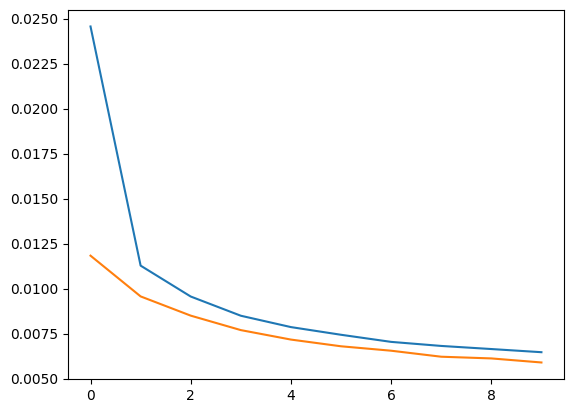

In [15]:
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])

In [16]:
for key, val in history['train_cr'][-1].items():
  print(key, val)

0 {'precision': 0.9988924642547545, 'recall': 0.9991607324308546, 'f1-score': 0.9990265803333205, 'support': 1221303.0}
1 {'precision': 0.8727272727272727, 'recall': 0.411663807890223, 'f1-score': 0.5594405594405595, 'support': 1166.0}
2 {'precision': 0.9957022856026567, 'recall': 0.9935672514619883, 'f1-score': 0.9946336227924676, 'support': 5130.0}
3 {'precision': 0.9984270587561264, 'recall': 0.9975749501719912, 'f1-score': 0.99800082257821, 'support': 192161.0}
4 {'precision': 1.0, 'recall': 0.2727272727272727, 'f1-score': 0.42857142857142855, 'support': 22.0}
5 {'precision': 0.9825922638646319, 'recall': 0.9981386150132333, 'f1-score': 0.9903044293752705, 'support': 34383.0}
6 {'precision': 0.9245439469320066, 'recall': 0.8772619984264359, 'f1-score': 0.9002825999192572, 'support': 1271.0}
accuracy 0.9983194039449347
macro avg {'precision': 0.9675550417339213, 'recall': 0.7928706611602855, 'f1-score': 0.8386085775729305, 'support': 1455436.0}
weighted avg {'precision': 0.998268713

## Load Trained Model

In [90]:
torch.save(model.state_dict(), '../trained_models/base_mlp_model_49_64_64_7.pth')

In [91]:
# Load the saved model state
model = MLP(num_features=49, hidden1_size=64, hidden2_size=64, num_classes=7)
model.load_state_dict(torch.load('../trained_models/base_mlp_model_49_64_64_7.pth'))
model.eval()

MLP(
  (fc1): Linear(in_features=49, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)

In [92]:
y_preds = []
y_trues = []

with torch.no_grad():
  for inputs, labels in test_loader:
    outputs = model(inputs)
    
    # get metrics
    y_preds += outputs.argmax(axis=1).tolist()
    y_trues += labels.tolist()

y_preds_tensor = torch.tensor(y_preds)
y_trues_tensor = torch.tensor(y_trues)
y_trues_tensor = torch.flatten(y_trues_tensor)

In [94]:
# Calculate accuracy
accuracy = (y_preds_tensor == y_trues_tensor).float().mean().item() * 100
accuracy

99.8414933681488

View data

In [2]:
train_data, _, _ = get_dataset()

In [10]:
train_data.features.describe()

,destination_port,fwd_packet_length_max,fwd_packet_length_min,fwd_packet_length_std,bwd_packet_length_min,bwd_packet_length_std,flow_bytes_s,flow_iat_mean,flow_iat_std,flow_iat_min,...,init_win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,active_mean,active_std,active_max,active_min,idle_std,idle_max,idle_min
count,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,...,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06,1.455436e+06
mean,4.951610e-01,4.956638e-01,3.849144e-01,3.195197e-01,3.644973e-01,2.750863e-01,4.953294e-01,5.050034e-01,4.572275e-01,5.031677e-01,...,3.844423e-01,4.515377e-01,4.987845e-01,2.037090e-01,8.087351e-02,2.039952e-01,2.037888e-01,8.954977e-02,2.054445e-01,2.056252e-01
std,2.806566e-01,3.003694e-01,3.864555e-01,3.985830e-01,3.920244e-01,3.950133e-01,2.882618e-01,2.885712e-01,3.428685e-01,2.854942e-01,...,3.839501e-01,3.396251e-01,2.559841e-01,3.736536e-01,2.664370e-01,3.742390e-01,3.738930e-01,2.778555e-01,3.734963e-01,3.737565e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.781782e-01,2.167167e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.398276e-01,2.562563e-01,0.000000e+00,3.518519e-01,...,0.000000e+00,0.000000e+00,2.612613e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.569570e-01,5.080080e-01,4.939940e-01,0.000000e+00,0.000000e+00,0.000000e+00,4.928396e-01,5.074921e-01,5.013056e-01,4.984985e-01,...,5.080080e-01,4.809810e-01,2.612613e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.811812e-01,7.495921e-01,7.552553e-01,7.502503e-01,7.507508e-01,7.467157e-01,7.457624e-01,7.560932e-01,7.537556e-01,7.512513e-01,...,7.302302e-01,7.677678e-01,7.557558e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
